IMPORTING DEPENDENCIES

In [1]:
#%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Reshape
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, BatchNormalization

PREPROCESSING THE TRAINING SET

In [3]:
# Specify your dataset directory
dataset_dir = 'train'

# Use ImageDataGenerator for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

# Create a generator for all images in the dataset
norm_data_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=(64, 64),  # Adjust the target size according to your needs
    batch_size=64,
    class_mode='input',  # Assuming it's an autoencoder (modify if needed)
    color_mode='grayscale',  # 'grayscale' for grayscale
    shuffle=True
)




Found 1349 images belonging to 1 classes.


PREPROCESSING THE TEST SET

In [4]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set_normal = test_datagen.flow_from_directory('test',
                                            target_size = (64, 64),
                                            batch_size = 64,
                                            class_mode = 'input',
                                            shuffle=True,
                                            color_mode='grayscale')

Found 234 images belonging to 1 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set_anomalous = test_datagen.flow_from_directory('test_anomalous',
                                            target_size = (64, 64),
                                            batch_size = 64,
                                            class_mode = 'input',
                                            shuffle=True,
                                            color_mode='grayscale')

Found 390 images belonging to 1 classes.


AUTOENCODER-CONVOLUTIONAL NEURAL NETWORK MODEL

In [6]:
# Define the encoder
encoder_input = Input(shape=(64,64,1))
encoder = Conv2D(8, kernel_size=4, strides=2, padding="same", activation="relu")(encoder_input)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(16, kernel_size=4, strides=2, padding="same", activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(32, kernel_size=4, strides=2, padding="same", activation="relu")(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(64, kernel_size=4, strides=2, padding="same", activation="relu")(encoder)
encoder = BatchNormalization()(encoder)

# Latent Space
encoder = Flatten()(encoder)
encoder = Dense(2048, activation='relu')(encoder)
encoder = Dense(16)(encoder)
encoder = Dense(2048, activation='relu')(encoder)
decoder = Dense(4*4*64 ,activation='relu')(encoder) # Latent Space

In [7]:
#Define the decoder
decoder = Reshape((4,4,64))(decoder)
decoder = Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", activation="relu")(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2DTranspose(16, kernel_size=4, strides=2, padding="same", activation="relu")(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2DTranspose(8, kernel_size=4, strides=2, padding="same", activation="relu")(decoder)
decoder = BatchNormalization()(decoder)
decoder_output = Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation="tanh")(decoder)


In [8]:
# Train the AE-CNN model
AE_CNN = Model(inputs=encoder_input, outputs=decoder_output)
AE_CNN.compile(optimizer='adam', loss='mse')

In [9]:
#AE_CNN.summary()

In [10]:
AE_CNN.fit(norm_data_gen, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
22/22 [==============================] - 69s 3s/step - loss: 0.3197
Epoch 2/100
22/22 [==============================] - 55s 3s/step - loss: 0.1997
Epoch 3/100
22/22 [==============================] - 70s 3s/step - loss: 0.1377
Epoch 4/100
22/22 [==============================] - 61s 3s/step - loss: 0.0890
Epoch 5/100
22/22 [==============================] - 60s 3s/step - loss: 0.0624
Epoch 6/100
22/22 [==============================] - 58s 3s/step - loss: 0.0411
Epoch 7/100
22/22 [==============================] - 54s 2s/step - loss: 0.0394
Epoch 8/100
22/22 [==============================] - 53s 2s/step - loss: 0.0306
Epoch 9/100
22/22 [==============================] - 63s 3s/step - loss: 0.0336
Epoch 10/100
22/22 [==============================] - 57s 3s/step - loss: 0.0264
Epoch 11/100
22/22 [==============================] - 61s 3s/step - loss: 0.0260
Epoch 12/100
22/22 [==============================] - 63s 3s/step - loss: 0.0229
Epoch 13/100
22/22 [=================

In [11]:
AE_CNN.save('ae_cnn_model.h5') # Save the model

C:\Users\nosao\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


EVALUATING USING RECONSTRUCTION ERROR

In [12]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('test_all',
                                            target_size = (64, 64),
                                            batch_size = 64,
                                            class_mode = 'input',
                                            shuffle=True,
                                            color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [13]:
model_test_out = AE_CNN.predict(test_set)
model_test_out.shape

10/10 [==============================] - 32s 3s/step


(624, 64, 64, 1)

In [14]:
# Use list comprehension to load and concatenate batches
test_set_reshape = np.concatenate([next(test_set)[0] for _ in range(len(test_set))], axis=0)

# Check the shape of the resulting array
print(test_set_reshape.shape)

(624, 64, 64, 1)


In [15]:
mse = np.mean(np.power(test_set_reshape - model_test_out, 2),axis=(1, 2))

In [16]:
mse

array([[0.04319808],
       [0.01513822],
       [0.05911428],
       [0.0147072 ],
       [0.04065172],
       [0.02110455],
       [0.07530326],
       [0.06721461],
       [0.02853219],
       [0.02802363],
       [0.05028343],
       [0.0256513 ],
       [0.04569714],
       [0.01938851],
       [0.05594523],
       [0.01360153],
       [0.03733248],
       [0.05662714],
       [0.0228541 ],
       [0.02417243],
       [0.06710778],
       [0.02087693],
       [0.0390727 ],
       [0.06005515],
       [0.10207579],
       [0.01535991],
       [0.08050993],
       [0.02658786],
       [0.0338881 ],
       [0.05183478],
       [0.02590491],
       [0.03384294],
       [0.02117532],
       [0.02829907],
       [0.03602695],
       [0.04877165],
       [0.03811446],
       [0.01609404],
       [0.04118703],
       [0.02310012],
       [0.07089483],
       [0.07092016],
       [0.03054399],
       [0.04302077],
       [0.03258074],
       [0.02126877],
       [0.05024846],
       [0.020

In [17]:
model_test_normal_out = AE_CNN.predict(test_set_normal)
model_test_normal_out.shape

4/4 [==============================] - 11s 3s/step


(234, 64, 64, 1)

In [18]:
#test_set_normal

In [19]:
model_test_anomalous_out = AE_CNN.predict(test_set_anomalous)
model_test_anomalous_out.shape

7/7 [==============================] - 13s 2s/step


(390, 64, 64, 1)

In [20]:
test_set_normal_reshape = np.concatenate([next(test_set_normal)[0] for _ in range(len(test_set_normal))], axis=0)

In [21]:
test_set_normal_reshape.shape

(234, 64, 64, 1)

In [22]:
mse_normal = np.mean(np.power(test_set_normal_reshape - model_test_normal_out, 2),axis=(1, 2))

In [23]:
mse_normal

array([[0.04778776],
       [0.04054537],
       [0.02758424],
       [0.0206734 ],
       [0.03282933],
       [0.01451942],
       [0.04499431],
       [0.04679092],
       [0.04120163],
       [0.06658909],
       [0.08633852],
       [0.01835966],
       [0.02581488],
       [0.02715531],
       [0.03066681],
       [0.09438856],
       [0.05671287],
       [0.0547673 ],
       [0.05917666],
       [0.1027917 ],
       [0.02094158],
       [0.0341096 ],
       [0.07432915],
       [0.03196569],
       [0.05740875],
       [0.0317612 ],
       [0.04645478],
       [0.03873646],
       [0.05438527],
       [0.01918437],
       [0.03806675],
       [0.07678358],
       [0.04742169],
       [0.02038607],
       [0.0471579 ],
       [0.02430422],
       [0.04032435],
       [0.06662079],
       [0.03564972],
       [0.04160247],
       [0.05381387],
       [0.03204162],
       [0.0235527 ],
       [0.05343527],
       [0.0476105 ],
       [0.03350249],
       [0.03220211],
       [0.027

In [24]:
mse_normal_list = mse_normal.tolist()
# Creating the DataFrame
error_df = pd.DataFrame({'Reconstruction_Error': mse_normal_list})
display(error_df)

,Reconstruction_Error
0,[0.047787755727767944]
1,[0.040545374155044556]
2,[0.027584237977862358]
3,[0.020673401653766632]
4,[0.03282933309674263]
...,...
229,[0.06396078318357468]
230,[0.023677941411733627]
231,[0.04950973391532898]
232,[0.04924701154232025]


In [25]:
# Use list comprehension to load and concatenate batches
test_set_anomalous_reshape = np.concatenate([next(test_set_anomalous)[0] for _ in range(len(test_set_anomalous))], axis=0)

# Check the shape of the resulting array
print(test_set_anomalous_reshape.shape)

(390, 64, 64, 1)


In [26]:
mse_anomalous = np.mean(np.power(test_set_anomalous_reshape - model_test_anomalous_out, 2),axis=(1, 2))

mse_anomalous_list = mse_anomalous.tolist()
# Creating the DataFrame
error_df_anomalous = pd.DataFrame({'Reconstruction_Error': mse_anomalous_list})
display(error_df_anomalous)

,Reconstruction_Error
0,[0.037505555897951126]
1,[0.016306858509778976]
2,[0.03818584978580475]
3,[0.024367589503526688]
4,[0.01819467730820179]
...,...
385,[0.03442154824733734]
386,[0.03327660635113716]
387,[0.08185343444347382]
388,[0.023520169779658318]


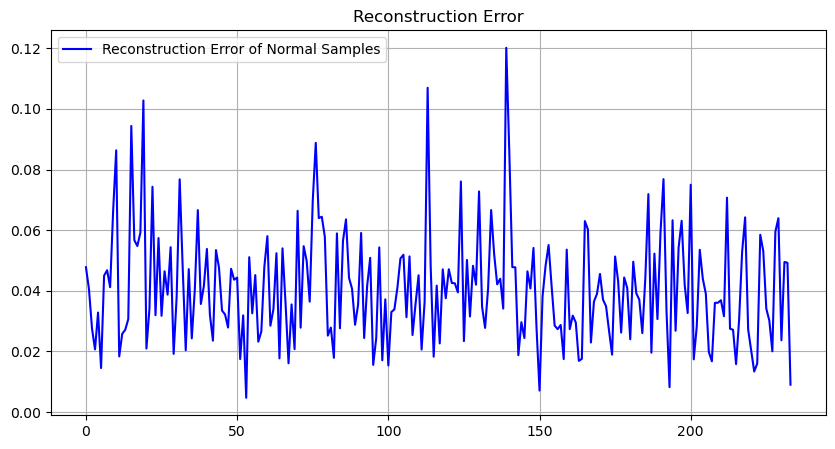

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(mse_normal, label='Reconstruction Error of Normal Samples', color='b')
plt.legend()
plt.title('Reconstruction Error')
plt.grid(True)
plt.show()


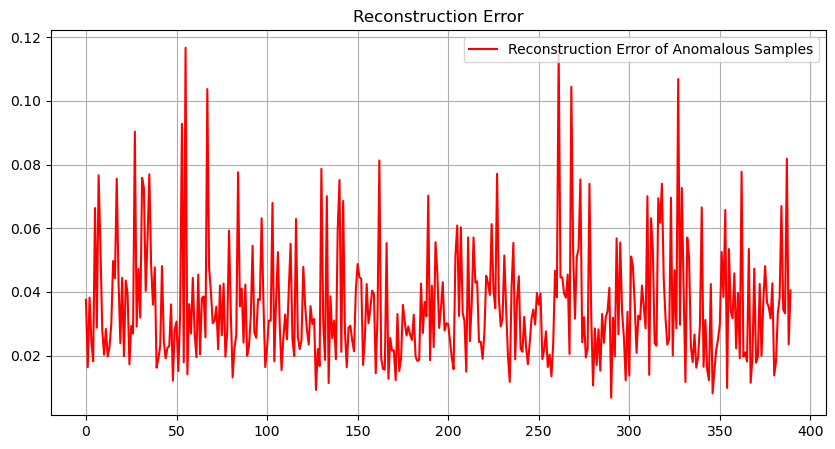

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(mse_anomalous, label='Reconstruction Error of Anomalous Samples', color='r')
plt.legend()
plt.title('Reconstruction Error')
plt.grid(True)
plt.show()


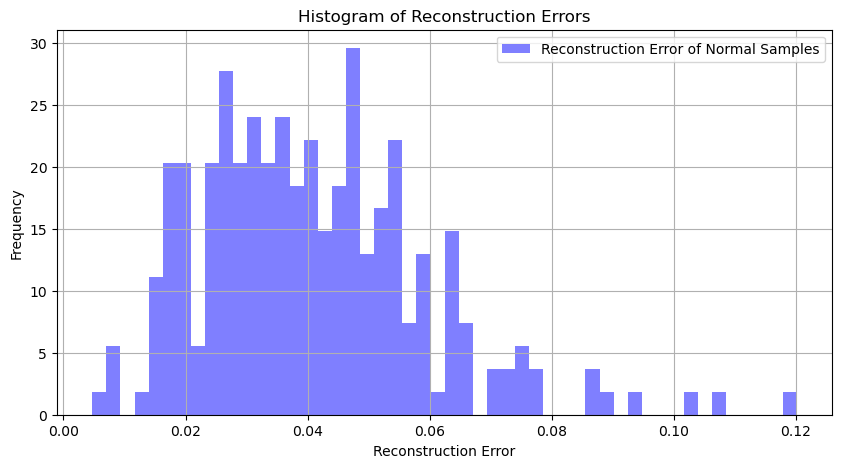

In [29]:
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, label='Reconstruction Error of Normal Samples', bins=50, density=True, alpha=0.5, color='blue')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.grid(True)
plt.legend()
plt.show()

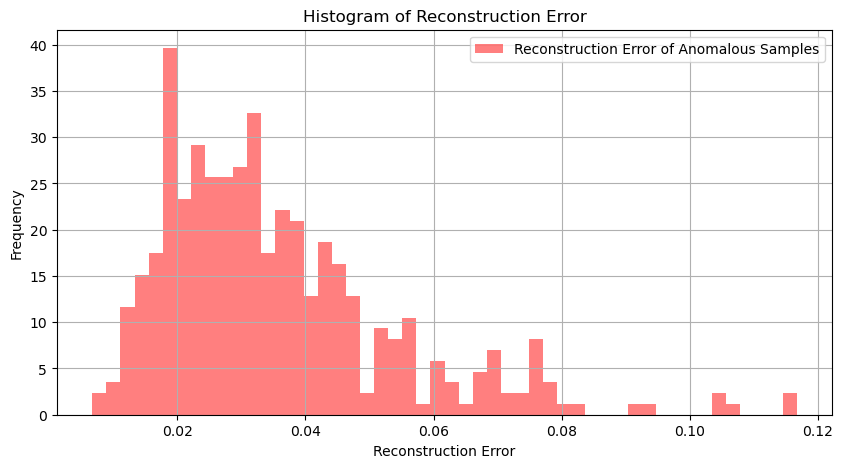

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(mse_anomalous, label='Reconstruction Error of Anomalous Samples', bins=50, density=True, alpha=0.5, color='red')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Error')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
threshold = 0.0127

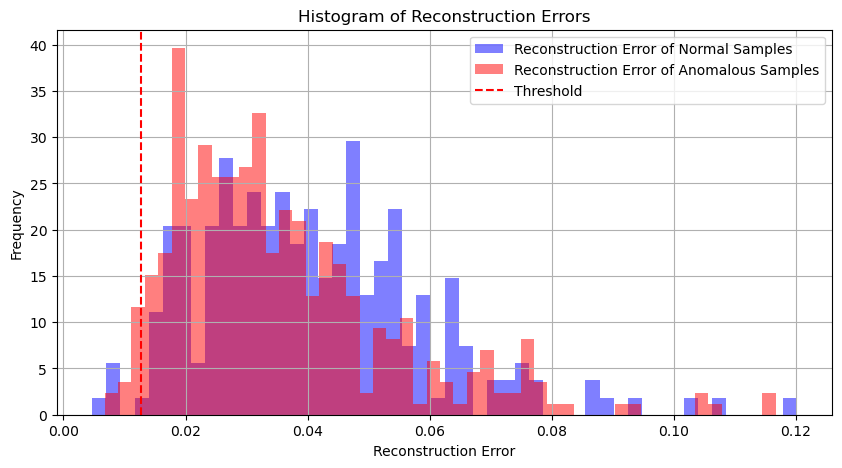

In [32]:
plt.figure(figsize=(10, 5))
plt.hist(mse_normal, label='Reconstruction Error of Normal Samples', bins=50, density=True, alpha=0.5, color='blue')
plt.hist(mse_anomalous, label='Reconstruction Error of Anomalous Samples', bins=50, density=True, alpha=0.5, color='red')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
predicted_label = (mse > threshold).astype(int)
true_label = np.array([0] * 234 + [1] * 390)

from sklearn.metrics import roc_auc_score # area under curve

roc_auc = roc_auc_score(true_label, predicted_label)
roc_auc 

0.5025641025641026

SYSTEM SAMPLE

In [34]:
# To load the model later:
#loaded_model = load_model('ae_cnn_model.h5')

In [35]:
from keras.preprocessing import image

In [36]:
# Load the image using image.load_img
sample_image_path = 'C:/Users/nosao/Downloads/Final year project_anomaly detection/Pediatric Chest X-ray Pneumonia/Sample-image-anomalous/sample.jpeg'
sample_img = image.load_img(sample_image_path, target_size=(64, 64), color_mode="grayscale")

# Convert the image to a numpy array
img_array = image.img_to_array(sample_img)

# Normalize the pixel values
normalized_image = img_array / 255.0  # assuming pixel values are in the range [0, 255]

# Add batch and channel dimensions
input_image = np.expand_dims(np.expand_dims(normalized_image, axis=0), axis=3)


In [37]:
reconstructed_img = AE_CNN.predict(input_image)

1/1 [==============================] - 1s 710ms/step


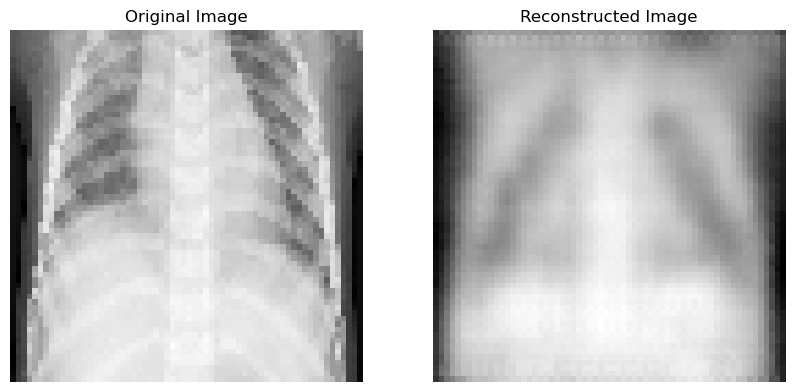

In [38]:
# Plotting the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img.reshape((64, 64, 1)), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()